In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

2023-05-31 16:37:59.834137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TEST_PATH = "dataset/test/"
TEST_TOP10_PATH = "dataset/test_top10/"
TEST_LAST10_PATH = "dataset/test_last10/"
TEST_DIRS = glob.glob("dataset/test/*")
TEST_TOP10_DIRS = glob.glob("dataset/test_top10/*")
TEST_LAST10_DIRS = glob.glob("dataset/test_last10/*")

MODELS = ["food-seg-103-xception", "food-seg-103-densenet121", "food-seg-103-densenet201"]
CHECKPOINT_PATHS = ["checkpoints/" + MODEL + ".h5" for MODEL in MODELS]
MODEL_PATHS = ["models/" + MODEL + ".h5" for MODEL in MODELS]

IMAGE_SIZE = 512

In [3]:
def acc_top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [4]:
def load_models():
    loaded_models = []
    for CHECKPOINT_PATH in CHECKPOINT_PATHS:
        loaded_models.append(load_model(CHECKPOINT_PATH, custom_objects={"acc_top5": acc_top5}))
    print("Models Loaded")
    return loaded_models

In [5]:
models = load_models()

Models Loaded


In [6]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_data = test_datagen.flow_from_directory(
    TEST_LAST10_PATH,
    batch_size=1,
    shuffle=False,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode="categorical")
filenames = test_data.filenames

Found 24 images belonging to 104 classes.


In [7]:
def evaluate(model):
    test_score = model.evaluate(test_data)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    print("Test Accuracy Top 5: ", test_score[2])

In [8]:
for i, model in enumerate(models):
    print("=" * 100)
    print(MODELS[i])
    evaluate(model)
    print("=" * 100)

food-seg-103-xception


2023-05-31 16:38:23.987216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 9s 335ms/step - loss: 5.1605 - accuracy: 0.0833 - acc_top5: 0.2083
Test Loss:  5.160521030426025
Test Accuracy:  0.0833333358168602
Test Accuracy Top 5:  0.2083333283662796
food-seg-103-densenet121


2023-05-31 16:38:33.442927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 18s 667ms/step - loss: 6.0680 - accuracy: 0.0417 - acc_top5: 0.2500
Test Loss:  6.068038463592529
Test Accuracy:  0.0416666679084301
Test Accuracy Top 5:  0.25
food-seg-103-densenet201


2023-05-31 16:38:51.800764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 42s 1s/step - loss: 5.8357 - accuracy: 0.0833 - acc_top5: 0.1250
Test Loss:  5.8357367515563965
Test Accuracy:  0.0833333358168602
Test Accuracy Top 5:  0.125


In [9]:
def predict(model):
    predicted_class_indices = []

    with tqdm(total=len(test_data.filepaths)) as pbar:
        for i, filepath in enumerate(test_data.filepaths):
            pbar.set_description("Predicting: %d" % (1 + i))
            pbar.update(1)
            test_image = load_img(filepath, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            test_image_array = img_to_array(test_image)
            test_image_array = np.expand_dims(test_image_array, axis=0)
            test_image_array = test_image_array / 255.
            prediction = model.predict(test_image_array, verbose=0)
            predicted_label = np.argmax(prediction)
            predicted_class_indices.append(predicted_label)
    
    predicted_class_indices = np.asarray(predicted_class_indices)

    predicted_classnames = []
    true_classnames = []
    for i in range(len(filenames)):
        predicted_classnames.append(list(test_data.class_indices.keys())[predicted_class_indices.item(i)])
        true_classnames.append(list(test_data.class_indices.keys())[test_data.labels[i]])
    return pd.DataFrame({"Filename": filenames, "Prediction": predicted_classnames, "True": true_classnames})

In [10]:
results = []
for model in models:
    results.append(predict(model))

Predicting: 24: 100%|███████████████████████████| 24/24 [00:44<00:00,  1.86s/it]


In [11]:
mismatched_results = []
for i, result in enumerate(results):
    test_accuracy = result.loc[(result["Prediction"] == result["True"])].shape[0] / result.shape[0]
    mismatched_result = result.loc[~(result["Prediction"] == result["True"])]
    mismatched_results.append(mismatched_result)
    print(MODELS[i] + ": " + "Test Accuracy: " + str(test_accuracy) + ", Mismatch: " + str(len(mismatched_result)))

food-seg-103-xception: Test Accuracy: 0.08333333333333333, Mismatch: 22
food-seg-103-densenet121: Test Accuracy: 0.041666666666666664, Mismatch: 23
food-seg-103-densenet201: Test Accuracy: 0.08333333333333333, Mismatch: 22


In [12]:
results[0].sample(10)

,Filename,Prediction,True
17,popcorn/00007024.png,sauce,popcorn
3,date/00004718.png,sauce,date
1,bamboo shoots/00007056.png,pineapple,bamboo shoots
9,hamburg/00005585.png,bread,hamburg
0,bamboo shoots/00006926.png,pineapple,bamboo shoots
5,egg tart/00006972.png,shiitake,egg tart
13,peanut/00007101.png,corn,peanut
15,popcorn/00006908.png,pasta,popcorn
20,seaweed/00004893.png,chocolate,seaweed
16,popcorn/00006948.png,popcorn,popcorn


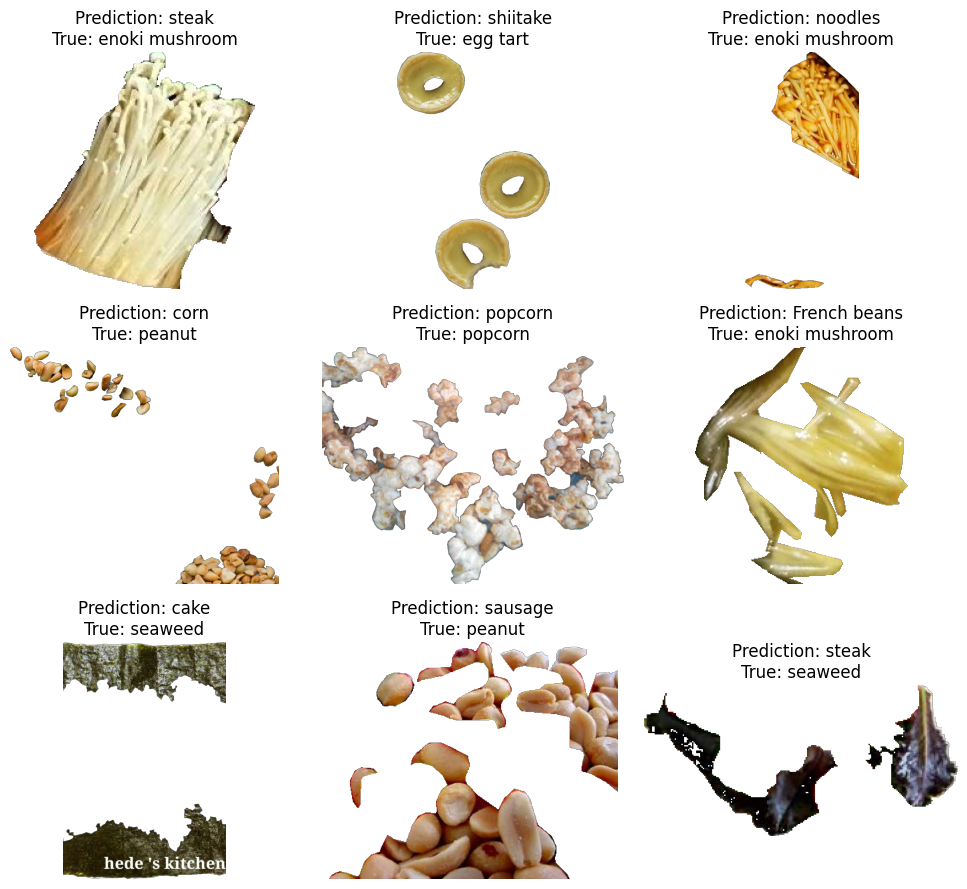

In [13]:
plt.figure(figsize=(10, 9))

for idx, row in results[0].sample(9).reset_index(drop=True).iterrows():
    plt.subplot(3, 3, idx + 1)
    img = plt.imread(TEST_LAST10_PATH + row["Filename"])
    plt.title("Prediction: " + row["Prediction"] + "\nTrue: " + row["True"])
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.tight_layout()

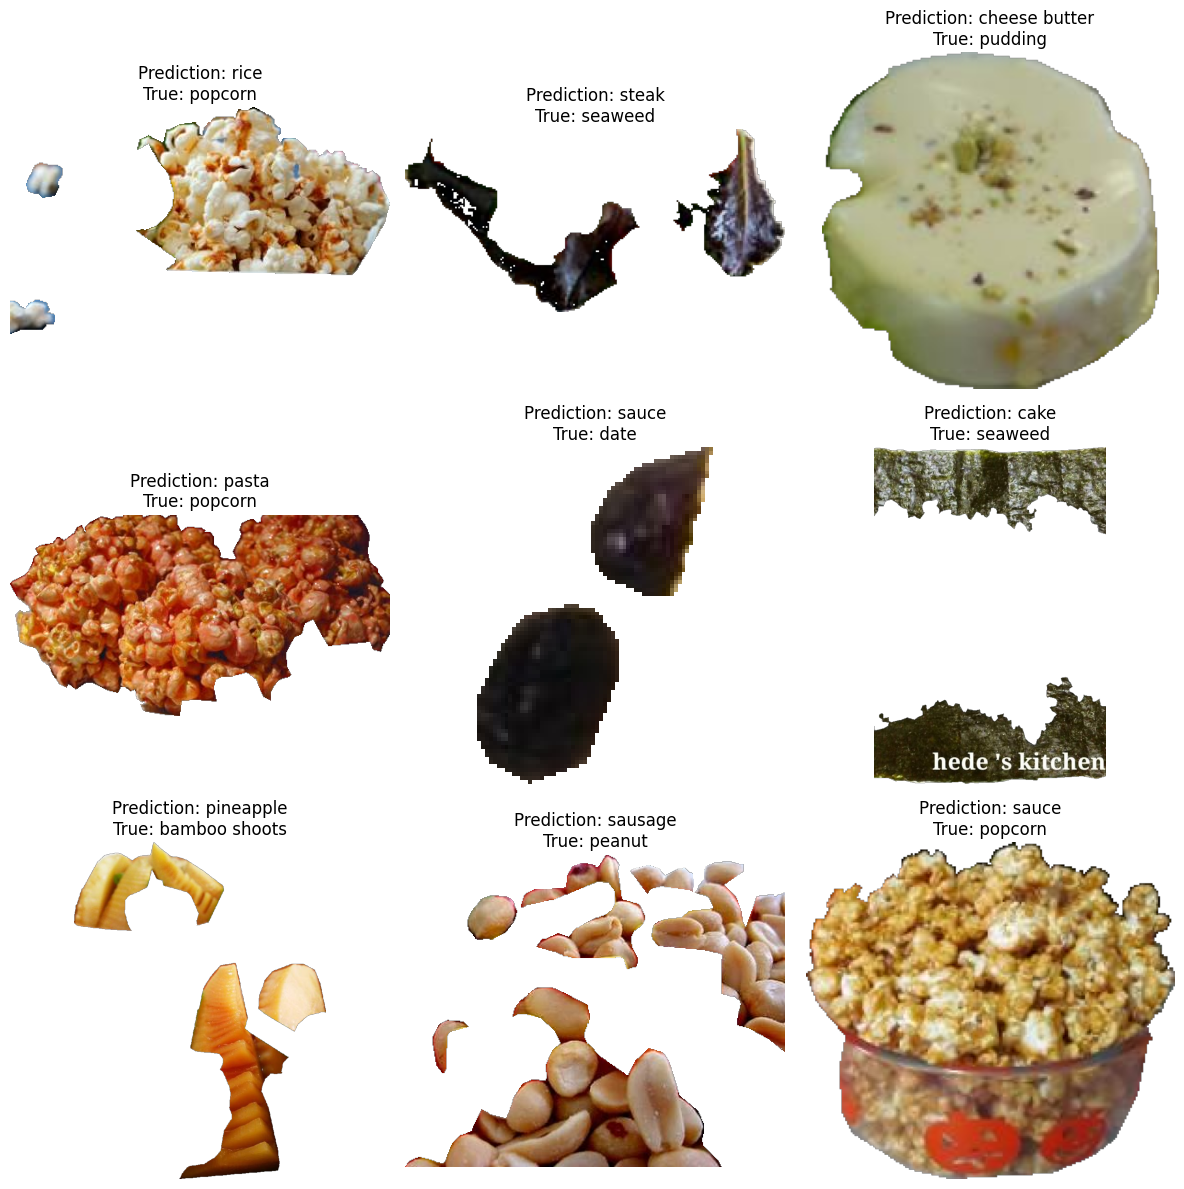

In [14]:
plt.figure(figsize=(12, 12))

for idx, row in mismatched_results[0].sample(9).reset_index(drop=True).iterrows():
    plt.subplot(3, 3, idx + 1)
    img = plt.imread(TEST_LAST10_PATH + row["Filename"])
    plt.title("Prediction: " + row["Prediction"] + "\nTrue: " + row["True"])
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.tight_layout()

In [15]:
ensemble_result = {}
for i, result in enumerate(results):
    ensemble_result[i] = result["Prediction"]
ensemble_result["True"] = results[0]["True"]
ensemble_result = pd.DataFrame(ensemble_result)
ensemble_result.sample(10)

,0,1,2,True
9,bread,cake,bread,hamburg
13,corn,almond,almond,peanut
14,rice,rice,other ingredients,popcorn
11,cucumber,pepper,pineapple,kelp
7,noodles,noodles,noodles,enoki mushroom
3,sauce,blueberry,olives,date
15,pasta,pizza,pasta,popcorn
18,cheese butter,cheese butter,ice cream,pudding
6,steak,noodles,ice cream,enoki mushroom
5,shiitake,shiitake,egg,egg tart


In [16]:
def get_ensemble_result():
    truth = 0
    for index, row in ensemble_result.iterrows():
        predictions = list(row)[:-1]
        prediction = max(set(predictions), key=predictions.count)
        label = list(row)[-1:][0]
        if prediction == label:
            truth += 1
    return truth / ensemble_result.shape[0]

In [17]:
print("Ensemble Test Accuracy: " + str(get_ensemble_result()))

Ensemble Test Accuracy: 0.08333333333333333
